# DATATHON 
##### Detecting Pricing Anomalies
### IE MBD-O2

#### Submission 
### TEAM C : Amartya | Ceci | Karim | Mike | Pau


![title](hotelbed.jpg)

## Approach Abstract

Detecting outliers or anomalies in pricing from the bookings data is an unsupervised learning problem. We will approach the problem with a three-pronged flow:
##### 1. Tag Explicit Errors and Meaningless Values
##### 2. Remove extreme values contrary to domain standards
##### 2. Check for statistical outliers based on calculated Outlier Score
##### 3. Cluster similar bookings based on pricipal components and detect statistical outliers


<img src="Intro.png" alt="Drawing" style="width: 500px;"/>


We proceed with the above approach while forming 2 basic assumption/hypothesis:
1. clusters or features that have higher standard deviations, kurtosis or extreme values are more likely to contain anomalies
2. Total anomalies will probably not be higher than 1% of the data set

The above approach is implemented by exploring the data set and at each level we create sub-sets of the data that are likely to be anomalies. In the end we combine all of these and create the final tag = 1 for anomalies, 0 for genuine. 

## Table of contents
1. [Initialization](#initialization)
2. [Basic Data Exploration,Feature Creation and Transformation](#bda)
3. [Feature Analysis](#fa)
    1. [ContractID](#contID)
    2. [Star Rating](#star)
    3. [Room Type](#room)
    4. [Arrival Month](#month)
    5. [Category](#cat)
    6. [Meal Basis](#meal)
    7. [Contract Type](#contract)
    8. [Other Date Variables](#date)
    9. [Time Variables](#time)
    10. [City](#city)
    11. [Hotel Key](#hotel)
4. [Data Set Transformation](#transformation)
5. [Outlier/Anomaly Detection](#outlierDetection)    
    1. [Statistical and Visual Approach](#stat)
    2. [Clustering and Regression Approach](#cluster)
5. [Anomaly Labeling and Submission](#submit)

### Initialization <a name="initialization"></a>

In [1]:
#pip install workdays

In [1]:
# importing primary libraries
import numpy as np
import pandas as pd
from collections import Counter
import datetime as dt
import workdays
import glob
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# reading data set
df = pd.read_csv('DATATHON_STU_NEW.csv', index_col= 0)
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,departure_date,total_cost,star_rating,row_id
0,-8311839113995541010,3308171939935307043,-6758561262332566539,1,BL-6,OPQ,APT,RO,2018-05-22,2018-06-30,2018-07-05,14192.496000,APARTMENT,0
1,-7782336419181110673,-3269338087318960614,-9183082468560560492,8,ST,NOR,DBT,BB,2018-05-22,2018-07-20,2018-07-24,3558.469200,1,1
2,-8185637807857201025,-7171383991101553094,-573449065418159891,6,XX-KG-SU,NOR,DBL,RO,2018-05-22,2018-05-24,2018-05-29,17319.714354,5,2
3,4398388086357359587,3421074771505167982,215759992217563846,2,ST,NONE,TWN,BB,2018-05-22,2018-06-08,2018-06-11,3321.785004,3,3
4,-7098207282290159573,7965439627984399332,1006074091123194605,7,ST,NOR,DBT,RO,2018-05-22,2018-06-11,2018-06-14,2586.300000,3,4


In [3]:
# Checking properties of the data set
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(899477, 14)
hotel_hkey            int64
contract_id_hkey      int64
id_hkey               int64
city_code             int64
category_room        object
contract_type        object
room_type            object
meal_basis           object
creation_date        object
arrival_date         object
departure_date       object
total_cost          float64
star_rating          object
row_id                int64
dtype: object
hotel_hkey             0
contract_id_hkey       0
id_hkey                0
city_code              0
category_room          0
contract_type          0
room_type              0
meal_basis             0
creation_date          0
arrival_date           0
departure_date         0
total_cost          8813
star_rating            0
row_id                 0
dtype: int64


### Basic Data Exploration,Feature Creation and Transformation <a name="bda"></a>

We begin with exploring the data set. We first remove the obvious anomalies (step 1 of our approach) which are the Nulls and negetive prices

In [4]:
# Imputing nulls, negatives and zero values for costs into an 'anomaly' Data Frame.
df_anomaly1 = df.loc[(df.total_cost <= 0) | (df.total_cost.isnull()),:] 
df = df.loc[df.total_cost.notnull(), :] 
df = df.loc[df.total_cost > 0, :]

In [5]:
df_anomaly1.shape

(8820, 14)

Date variable has a lot of features hidden, we extract them and create new feature variables such as month, day etc for arrival, departure and booking

In [6]:
# Function definition for extracting days from delta time
def extractDays(td):
    return td.days

# Function to calculate working days between 2 dates
def cal_weekdays(a):
    return(workdays.networkdays(pd.to_datetime(a[0]),pd.to_datetime(a[1])))

In [7]:
# Create basic features out of the provided date variable
df["creation_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).month
df["creation_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).day
df["creation_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).weekday

df["arrival_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).month
df["arrival_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).day
df["arrival_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).weekday

df["departure_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).month
df["departure_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).day
df["departure_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).weekday

Using the variables previously created we decided to come up with new features based on the departure_date, arrival_date and creation_date:  

'**TripNoOfDays**' the duration of the trip

'**begEnd**' tuple of arrival_date and departure_date

'**TripWorkingDays**' number of working days during the trip

'**TripWeekends**' number of weekends during the trip

'**BookingLeadTime**' Lead time between booking and start of the trip

In [8]:
df["TripNoOfDays"] = pd.DatetimeIndex(pd.to_datetime(df.departure_date)) - pd.DatetimeIndex(pd.to_datetime(df.arrival_date)) 

df.TripNoOfDays =  df.TripNoOfDays.apply(extractDays)
df.TripNoOfDays = df.TripNoOfDays + 1

df['begEnd'] = df[['arrival_date', 'departure_date']].apply(tuple, axis=1)
df["TripWorkingDays"]  = df.begEnd.apply(cal_weekdays)
df["TripWeekends"] =   df.TripNoOfDays -  df.TripWorkingDays
df.loc[df.TripWeekends < 0,'TripWeekends'] = 0

df["BookingLeadTime"] = pd.DatetimeIndex(pd.to_datetime(df.arrival_date)) - pd.DatetimeIndex(pd.to_datetime(df.creation_date)) 
df.BookingLeadTime =  df.BookingLeadTime.apply(extractDays)

In [9]:
# Create feature 'price/cost' per night
df["PricePerNight"] = df.total_cost / df.TripNoOfDays
df["PricePerNight"] = df.PricePerNight.apply(int)

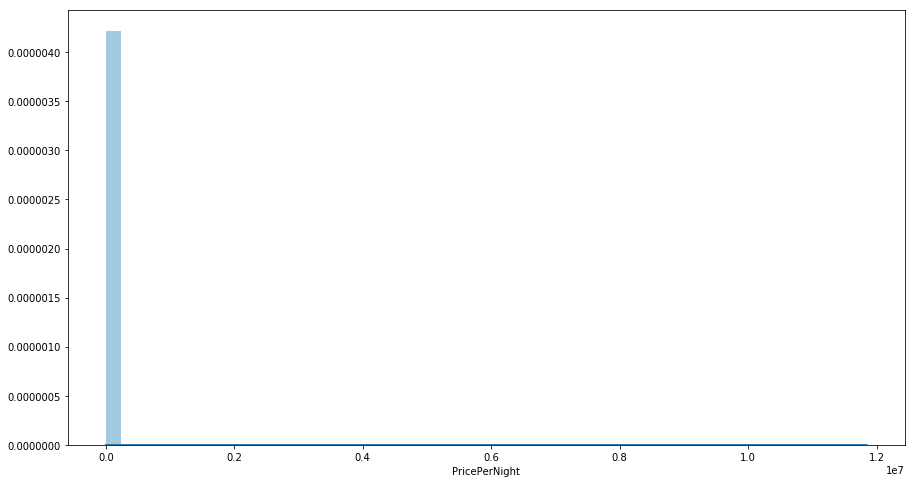

In [10]:
# Plot the distribution of 'PriceperNight' in millions
plt.figure(figsize=(15,8))
sns.distplot(df.loc[:,'PricePerNight']);    

In [11]:
# New list that comprises all the categorical variables from the Data Frame
categoricalVariables = ['city_code','category_room','contract_type','room_type','meal_basis',
                       'creation_date_month', 'creation_date_day',
                       'creation_date_weekday', 'arrival_date_month', 'arrival_date_day',
                       'arrival_date_weekday', 'departure_date_month', 'departure_date_day',
                       'departure_date_weekday','star_rating']

# Change the variable type of the previous list to 'category'
for i in categoricalVariables:
    df[i] = df[i].astype('category')

In [12]:
# Delete the variables we no longer need
df = df.drop(['id_hkey', 'creation_date', 'arrival_date', 'departure_date', 'begEnd', 'total_cost'], axis = 1)

#### Exploring the distribution of Variables

In [13]:
# Create two new Data Frames containing all the categorical and numerical features, respectively
categoricalVariables = df.select_dtypes(include=['category']).columns
numericalVariables = df.select_dtypes(include=['int64']).columns

In [14]:
#Describe all the columns
columnNames = df.columns
for i in columnNames:
    print(i)
    print(df[i].describe())

hotel_hkey
count    8.906570e+05
mean     1.197551e+16
std      5.235581e+18
min     -9.221152e+18
25%     -4.536184e+18
50%      2.100855e+17
75%      4.423175e+18
max      9.220866e+18
Name: hotel_hkey, dtype: float64
contract_id_hkey
count    8.906570e+05
mean     4.422421e+17
std      5.067546e+18
min     -9.223151e+18
25%     -3.949640e+18
50%      1.474372e+18
75%      3.766924e+18
max      9.222155e+18
Name: contract_id_hkey, dtype: float64
city_code
count     890657
unique         9
top            7
freq      174059
Name: city_code, dtype: int64
category_room
count     890657
unique      1320
top           ST
freq      407103
Name: category_room, dtype: object
contract_type
count     890657
unique         7
top          NOR
freq      494540
Name: contract_type, dtype: object
room_type
count     890657
unique        24
top          DBL
freq      342523
Name: room_type, dtype: object
meal_basis
count     890657
unique        17
top           BB
freq      416063
Name: meal_basis, 

In [15]:
# Drop variables that are no longer needed
categoricalVariables = categoricalVariables.drop(['category_room'])
numericalVariables = numericalVariables.drop(['row_id','hotel_hkey','contract_id_hkey'])

KeyError: "labels ['row_id' 'hotel_hkey' 'contract_id_hkey'] not contained in axis"

In [ ]:
# Visualize the count of occurrences by categories
for i,col in enumerate(categoricalVariables):
    plt.figure(i,figsize=(15,8))
    sns.countplot(df[col],hue = df[col], order=df[col].value_counts().index)
    plt.legend(loc='upper right')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.show()

We can see here that for many of the categorical variables the distribution/ count is extremely skewed towards a minor group of categories (levels). This provides some evidence to our hypothesis that low count categories with out of normal range prices may be anomalous in nature. Alternatively they can be realistic outliers and not anomalies.

In [ ]:
# Plot the distribution of the numerical variables 
for i, col in enumerate(numericalVariables):
    plt.figure(i, figsize=(15,8))
    sns.distplot(df.loc[:,col])  
    plt.show()

In booking lead time, we can observe a left tail corresponding to negative lead times, which are anomalies. However, these anomalies are not price related, this is why we will not include them in the final prediction.

In [ ]:
# Description of the price per nigt variable and the cut-off point of the 99.995 percentile
print(df.PricePerNight.describe())
print(np.percentile(df.PricePerNight, 99.995))

In [ ]:
# Number of the points on the left of the 0.005 percentile
print(np.percentile(df.PricePerNight, 0.005))

###### We see that the skew is denser upto 99%ile and becomes sparse at higher percentiles. Using basic statistical concepts related to normal distribution, we can assume price values above 99.995% lie as outliers with higher confidence levels. The same statistical rule can be applied on the lower side of the price band.

In [ ]:
# Number of the points on the left of the 0.01 percentile OR on the right of the 99.995 percentile
df.loc[(df.PricePerNight > np.percentile(df.PricePerNight, 99.995)) | (df.PricePerNight < np.percentile(df.PricePerNight, 0.01)) , :].shape

In [ ]:
# Saving the previous instances into a new Data Frame
df_anomaly2 = df.loc[(df.PricePerNight > np.percentile(df.PricePerNight, 99.995)) | (df.PricePerNight < np.percentile(df.PricePerNight, 0.01)) , :]
df = df.loc[(df.PricePerNight < np.percentile(df.PricePerNight, 99.995)) & (df.PricePerNight > np.percentile(df.PricePerNight, 0.01)) , :]

In [ ]:
df.shape

In [ ]:
df_anomaly2.describe()

In [ ]:
# Count of anomalies inside the dataframe 'df_anomaly2'
df_anomaly2.contract_id_hkey.unique().size

In [ ]:
# Heatmap of the cities per hotel against its price
plt.figure(figsize=(15,5))
sns.heatmap(df_anomaly2.groupby(["city_code", "contract_id_hkey"])['PricePerNight'].min().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Clearly they are mostly outliers among this sub data set. For now we can treat them as anomalies.

In [ ]:
# Scatter plot of the anomalies compressed per night in the Data Frame 'df_anomaly2'
plt.figure(figsize=(10,6))
plt.scatter(df_anomaly2.index,df_anomaly2.PricePerNight)
plt.ylabel('PricePerNight')

### Feature Analysis <a name="fa"></a>

#### Contract ID Key <a name="contID"></a>

##### The contract ID key represents a aggregation of properties of the booking based on the variables related to the hotel such as hotel, contract type, room type, meal basis and so on. Hence it is a good idea to create mean, median and standard deviation of the records grouped by the contract id. We can use the displacement of the price from these median values (considering the std dev and mean) as indicators of possible outliers or potential anomalies

In [ ]:
# Mean 'PricePerNight' grouped by all the contracts id's
contractIdMean = df.groupby(['contract_id_hkey'])['PricePerNight'].mean()

In [ ]:
# Function to return mean of each contract
def getContractMean(cid):
    return(contractIdMean[cid])

In [ ]:
# New column to store the difference between the 'PricePerNight' and the newly created 'ContractIdMean'
df['ContractIdMean'] = df.contract_id_hkey.apply(getContractMean)
df['priceDifbyContractMean'] = df['PricePerNight'] - df['ContractIdMean']
#df = df.drop(['ContractIdMean'], axis = 1)

#### Star Rating <a name="star"></a>

In [ ]:
# Description of the variable
df.star_rating.describe()

We see that the hotel star rating can be converted to ordinal scale of 1 to 5. For this we compare the median prices of each non numbered category with values of the star ratings for each of the corresponding cities/star. This way we can rank the non numbered star rating categories into numbered star ratings

In [ ]:
# Heatmap of the 'star_rating' per city against its 'PricePerNight'
plt.figure(figsize=(20,8))
sns.heatmap(df.groupby(["city_code", "star_rating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu", annot=True);

Based on the PricePerNight similarities between cities and star_rating, we grouped them and simplified the amount of categories from 22 to 5: (1,2,3,4,5) as HotelStarRating

In [ ]:
# Rules for Star Rating
Hotelratings = {
                ("APARTHOTEL",0): 5, ("APARTHOTEL",1): 4, ("APARTHOTEL",3): 3, ("APARTHOTEL",4): 4, ("APARTHOTEL",5): 4,
                ("APARTHOTEL",7): 2, ("APARTHOTEL",8): 4, ("APARTMENT",1): 4, ("APARTMENT",4): 4, ("APARTMENT",5): 5, 
                ("APARTMENT",7): 4, ("BED",0): 1, ("BED",1): 4, ("BED",2): 4, ("BED",4): 3, ("BED",8): 1, ("BOARDING",1): 4,
                ("BOUTIQUE",0): 3, ("BOUTIQUE",1): 1, ("BOUTIQUE",2): 3, ("BOUTIQUE",3): 5, ("BOUTIQUE",4): 4, 
                ("BOUTIQUE",7): 4, ("BOUTIQUE",8): 1, ("GUEST",4): 2, ("GUEST",5): 1, ("GUEST",8): 1, ("HOSTEL",1): 1,
                ("HOSTEL",2): 1, ("HOSTEL",3): 1, ("HOSTEL",4): 1, ("HOSTEL",5): 1, ("HOSTEL",6): 1, ("HOSTEL",7): 1,
                ("HOSTEL",8): 1, ("PENDING",2): 3, ("POUSADA",3): 3, ("RESIDENCE",1): 1, ("RESIDENCE",4): 5, 
                ("RESIDENCE",5): 4, ("RESIDENCE",7): 3, ("RESORT",0): 4, ("RESORT",3): 5, ("RESORT",8): 4, ("RURAL",1): 4,
                ("RURAL",2): 4, ("RURAL",8): 4, ("STANDARD",0): 4, ("STANDARD",7): 3, ("SUPERIOR",7): 4, ("SUPERIOR",8): 4,
                ("SUPERIOR",4): 4, ("SUPERIOR",0): 4, ("SUPERIOR",1): 4, ("SUPERIOR",5): 1, ("VACATIONALS",1): 4, 
                ("VILLA",0): 5, ("WITHOUT",1): 4, ("WITHOUT",2): 5, ("WITHOUT",3): 4, ("WITHOUT",4): 4, ("WITHOUT",5): 4,
                ("WITHOUT",6): 4, ("WITHOUT",7): 4
                }

In [ ]:
# Function to Return the Star rating of the booked Hotel based on the above Rule
def getRating(t):
    return(Hotelratings[t])

In [ ]:
# Create new variable 'combo' containing a touple with the 'star_rating' and the 'city_code'
df['combo'] = df[['star_rating', 'city_code']].apply(tuple, axis=1)

# Application of the aforementioned rules into the new feature 'HotelStarRating'
df['HotelStarRating'] = 0
df.loc[df.star_rating.isin(['5','4','3','2','1']),'HotelStarRating'] = df.star_rating
df.loc[df.HotelStarRating == 0, 'HotelStarRating'] =  df.loc[df.HotelStarRating == 0, :].combo.apply(getRating)
df.HotelStarRating = df.HotelStarRating.astype(int)

In [ ]:
# Edit the variable 'star_rating'so that it returns 'HOTEL' if the instance contains a number of stars
df.star_rating = df.star_rating.astype('object')
df.loc[df.star_rating.isin(['5','4','3','2','1']),'star_rating'] = 'HOTEL'

In [ ]:
df.star_rating.describe()

In [ ]:
# Heatmap of the edited 'star_rating' variable per city against its price
sns.heatmap(df.groupby(["city_code", "star_rating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
# Return the median and standard deviation of the 'PricePerNight' grouped by the 'star_rating'
print(df.groupby(["star_rating"])['PricePerNight'].median().sort_values(ascending = False))
#print(df.groupby(["star_rating"])['PricePerNight'].mean().sort_values(ascending = False))
print(df.groupby(["star_rating"])['PricePerNight'].std().sort_values(ascending = False))

In [ ]:
# Remove the variable 'combo' as we will no longer use it
df = df.drop(['combo'], axis = 1)

The type of hotel is not revealing much information. We will thus continue with using the ordinal scale from 1 : 5 as that has greater relevance for understanding the pricing

#### Room Type <a name="room"></a>

For room type we will take a standard approach of checkinig which room types have higher prices (on an average or as per median). Using this as a metric we will convert the categories into a ranked numerical scale which can have a better correlation to the prices


In [ ]:
# Describing the median of 'PricePerNight' per 'room_type' and count of the records in each type of room
print(df.groupby(["room_type"])['PricePerNight'].median().sort_values(ascending = False))
Counter(df['room_type']).most_common(26)

In [ ]:
# Creation of a new Data Frame containing the median of the 'PricePerNight' per 'room_type'
medianPriceByRoomType = df.groupby(["room_type"])['PricePerNight'].median().sort_values(ascending = False)

In [ ]:
# Add this feature into the main Data Frame
df['MedianPriceByRoomType'] = 0
for i in medianPriceByRoomType.index:
    df.loc[df.room_type == i,'MedianPriceByRoomType'] = medianPriceByRoomType[i]

#### Arrival Month <a name="month"></a>

Based on our understanding of tourism industry we have an hypothesis that PricePerNight tends to be higher in summer break months and december. We will go ahead and explore the distribution of prices by arrival month and verify this

In [ ]:
# matrix of the 'PricePerNight' by 'HotelStarRating' and 'arrival_date_month'
print(df.groupby(["arrival_date_month", "HotelStarRating"])['PricePerNight'].median().unstack())

# Heatmap of the edited 'arrival_date_month' variable per 'HotelStarRating' against its price
plt.figure(figsize=(15,8))
sns.heatmap(df.groupby(["HotelStarRating","arrival_date_month"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Based on the heatmap we confirm that the previous statement is true, and now a new varible will be created to group months with similar prices and a rank will be assigned based on price.

In [ ]:
# New feature 'monthRating' that group months with similar prices
df['monthRating'] = 0
df.loc[df.arrival_date_month.isin(['1','2']), 'monthRating'] = 1
df.loc[df.arrival_date_month.isin(['3','4','5']), 'monthRating'] = 5
#df.loc[df.arrival_date_month.isin(['11','12']), 'monthRating'] = 4
df.loc[df.arrival_date_month.isin(['6','9','10','11']), 'monthRating'] = 25
df.loc[df.arrival_date_month.isin(['7','8','12']), 'monthRating'] = 75

#### Category Room <a name="cat"></a>

A similar ranking apporoach will be used for category of the room as well. Since it has > 1000 category levels, not much information can be extracted apart from converting it to an ordinal scale of values

In [ ]:
# Count the number instances in each factor
Counter(df['category_room']).most_common(1319)

In [ ]:
# New Data Frame containing the median 'PricePerNight' be 'category_room'
categoryRoomPriceRank = df.groupby(["category_room"])['PricePerNight'].median().sort_values(ascending = False)

In [ ]:
# Creating rank for records based on 'room_category'
categoryRoomPriceRank = categoryRoomPriceRank.fillna(0)
maxi = max(categoryRoomPriceRank)
categoryRoomPriceRank = (categoryRoomPriceRank/maxi) * 100
categoryRoomPriceRank = categoryRoomPriceRank.astype(int)

In [ ]:
# Adding this feature to the main Data Frame
df['categoryRoomPriceRank'] = 0
for i in categoryRoomPriceRank.index:
    df.loc[df.category_room == i,'categoryRoomPriceRank'] = categoryRoomPriceRank[i]

In [ ]:
df.star_rating.describe()

#### Meal Basis <a name="meal"></a>

Meal basis will obviously have an influence on the price of the bookings. We can explore which meal categories are higher priced in general. Using this information we can create a score to force a postive correlation between meal basis and price per night

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.groupby(["city_code","meal_basis"])['PricePerNight'].median().sort_values(ascending= False).unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(["meal_basis", "HotelStarRating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.groupby(["city_code","meal_basis"])['PricePerNight'].std().sort_values(ascending= False).unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby([ "HotelStarRating","meal_basis"])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
# New feature for scoring based on the deviation of price from median grouped by 'mealBasis'
df['mealBasisDeviation'] = 1
df.loc[df.meal_basis.isin(['CB','FB','DB']),'mealBasisDeviation'] = 5
df.loc[df.meal_basis.isin(['HB','SC']),'mealBasisDeviation'] = 2

In [ ]:
df.groupby(["meal_basis"])['PricePerNight'].median().sort_values(ascending = False)

In [ ]:
df.groupby(["meal_basis"])['PricePerNight'].count().sort_values(ascending = False)

In [ ]:
# Create rank variable for 'meal_basis'
mealBasisRank = df.groupby(["meal_basis"])['PricePerNight'].median().sort_values(ascending = False)
mealBasisRank = mealBasisRank.fillna(0)
maxi = max(mealBasisRank)
mealBasisRank = (mealBasisRank/maxi) * 100
mealBasisRank = mealBasisRank.astype(int)

In [ ]:
# Adding this variable to the main Data Frame
df['mealBasisRank'] = 0
for i in mealBasisRank.index:
    df.loc[df.meal_basis == i,'mealBasisRank'] = mealBasisRank[i]

In [ ]:
df.head()

#### Contract Type <a name="contract"></a>

ContractID is already storing information of contract details of each booking. However we will dummify and re-group the contract type variable to reduce the number of levels

In [ ]:
# Violin plot describing the distribution of price per type of contract
plt.figure(figsize=(15,8))
sns.violinplot(x='contract_type', y='PricePerNight', data=df);

**NOR** - Normal

**NRF** - Non-Refundable

**NONE** - No Contract

**OPQ** - Opaque (Selling unsold travel inventory at a discounted price)

**NRF/OPQ** - Non-Refundable and Opaque

**SPE** - Special

**OTH** - Other

In [ ]:
df.groupby(["contract_type", "HotelStarRating"])['PricePerNight'].median().unstack()

In [ ]:
df.groupby(["contract_type"])['PricePerNight'].std().sort_values(ascending = False)

In [ ]:
df.groupby(["contract_type"])['PricePerNight'].count().sort_values(ascending = False)

In [ ]:
df.groupby(["contract_type"])['PricePerNight'].max().sort_values(ascending = False)

In [ ]:
# Regrouping and dummifying the contract type
df['contract_NOR'] = 0
df.loc[df.contract_type == 'NOR', 'contract_NOR'] = 1

df['contract_OPQ'] = 0
df.loc[(df.contract_type == 'OPQ')  | (df.contract_type == 'NRF/OPQ') , 'contract_OPQ'] = 1

df['contract_NRF'] = 0
df.loc[(df.contract_type == 'NRF')  | (df.contract_type == 'NRF/OPQ') , 'contract_NRF'] = 1

df['contract_UND'] = 0
df.loc[(df.contract_type == 'OTH')  | (df.contract_type == 'NONE') , 'contract_UND'] = 1

df['contract_SPE'] = 0
df.loc[(df.contract_type == 'SPE'), 'contract_SPE'] = 1

In [ ]:
# New feature for storing the contract deviation
df['contractDeviation'] = 1
df.loc[df.contract_type.isin(['OTH','NONE','SPE']),'contractDeviation'] = 5

#### Other Date Variables <a name="date"></a>

In [ ]:
dateVar = ['creation_date_month', 'creation_date_day', 'creation_date_weekday',
           'arrival_date_day', 'arrival_date_weekday']

In [ ]:
for i, var in enumerate(dateVar):
    plt.figure(i,figsize=(10,5))
    sns.heatmap(df.groupby(["HotelStarRating",var])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu")

In [ ]:
for i, var in enumerate(dateVar):
    plt.figure(i,figsize=(10,5))
    sns.heatmap(df.groupby(["HotelStarRating",var])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu")

Apart from month (analysed before) date Variables are not adding much value is not adding any additional Value to understand the median prices

#### Time Variables <a name="time"></a>

In [ ]:
# Scatter plot of price by 'BookingLeadTime'
sns.lmplot(x= 'BookingLeadTime', # Horizontal axis
           y= 'PricePerNight',   # Vertical axis
           data=df,              # Data source
           fit_reg=False,        # Don't fix a regression line
           );

In [ ]:
# By Trip Days
sns.lmplot(x= 'TripNoOfDays',  # Horizontal axis
           y= 'PricePerNight', # Vertical axis
           data=df,            # Data source
           fit_reg=False,      # Don't fix a regression line
           );

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
# Binning the higher values of the variables 'TripNoOfDays'
df.loc[df.TripNoOfDays.isin(range(15,20)), 'TripNoOfDays'] = 15
df.loc[df.TripNoOfDays.isin(range(20,31)), 'TripNoOfDays'] = 25
df.loc[df.TripNoOfDays.isin(range(31,45)), 'TripNoOfDays'] = 40
df.loc[df.TripNoOfDays.isin(range(45,60)), 'TripNoOfDays'] = 50
df.loc[df.TripNoOfDays.isin(range(60,90)), 'TripNoOfDays'] = 80
df.loc[df.TripNoOfDays >= 90 , 'TripNoOfDays'] = 100

df.groupby(['TripNoOfDays'])['PricePerNight'].count()

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

We can clearly see that time of the trip has an influence on the per night price. Specially the extreme high duration trips. Thus it would be good to bin the higher values of trip duration. Also provide added information on top of the trip duration by creating new variables that store a score based on the trip duration. The standard deviation reveals information on the propensity of a trip to have anomalous pricing. Thus we create new feature to score this propoensity as well.

In [ ]:
# New feature for deviation of price by duration 
df['DurationDeviation'] = 1
df.loc[df.TripNoOfDays.isin(range(7,15)),'DurationDeviation'] = 5
df.loc[df.TripNoOfDays.isin(range(15,50)),'DurationDeviation'] = 25
df.loc[df.TripNoOfDays > 50 ,'DurationDeviation'] = 125

In [ ]:
# Ranking trip duration
df['durationType'] = 1
df.loc[df.TripNoOfDays.isin(range(7,12)), 'durationType'] = 20
df.loc[df.TripNoOfDays.isin(range(12,50)), 'durationType'] = 5
df.loc[df.TripNoOfDays > 50, 'durationType'] = 10

In [ ]:
df.groupby(['TripWeekends'])['PricePerNight'].count()

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'TripWeekends'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'TripWeekends'])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Similar approach can be taken for the trip duration as well

In [ ]:
# Treating trip weekends just like trip duration
df.loc[df.TripWeekends.isin(range(5,11)), 'TripWeekends'] = 5
df.loc[df.TripWeekends >= 11 , 'TripWeekends'] = 11

In [ ]:
df['WeekendIncluded'] = 0
df.loc[(df.TripWeekends > 0), 'WeekendIncluded' ] = 1

In [ ]:
sns.heatmap(df.groupby(["HotelStarRating",'WeekendIncluded'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

#### City <a name="city"></a>

In [ ]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].count().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].min().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [ ]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

From the heat map we can clearly identfy cities that have relatively higher prices. We can hence group the cities and rank them based on the 'cost of living' that can be deduced from the exploration

In [ ]:
# Rank the cities based on median prices
df['cityRank'] = 1
df.loc[df.city_code.isin([5,6]), 'cityRank'] = 9
df.loc[df.city_code.isin([1,4,7,8]), 'cityRank'] = 3

df['cityDeviation'] = 1
df.loc[df.city_code.isin([8,5,1]), 'cityDeviation'] = 9
df.loc[df.city_code.isin([7,6,1]), 'cityDeviation'] = 3

In [ ]:
# Plotting the distribution of the price per city
for i, city in enumerate(df.city_code.cat.categories):
    plt.figure(i)
    #sns.distplot(train_data.loc[:,col], bins= 2)
    sns.distplot(df.loc[(df.city_code == city),'PricePerNight'])
    plt.xlabel(city, fontsize=12)

In [ ]:
# New variable that takes into account the kurtosis for the previously plotted distributions
df['CityKurtosis'] = 0
for i, city in enumerate(df.city_code.cat.categories):
    df.loc[(df.city_code == city),'CityKurtosis'] = df.loc[(df.city_code == city),'PricePerNight'].kurtosis()

In [ ]:
df.CityKurtosis = df.CityKurtosis.astype('int')

#### Hotel Key <a name="hotel"></a>

Though it makes sense to treat it just like contract, the information is already captured in the contractID and other hotel features. Thus it will not add any additional values

### Preparation and Transformation of Data Set <a name="transformation"></a>

In [ ]:
df.head()

In [ ]:
df = df.set_index('row_id')

In [ ]:
df.columns

In [ ]:
df.dtypes

In [ ]:
df.MedianPriceByRoomType = df.MedianPriceByRoomType.astype('int')
df.ContractIdMean = df.ContractIdMean.astype('int')
df.priceDifbyContractMean = df.priceDifbyContractMean.astype('int')

In [ ]:
df.shape

In [ ]:
# Dropping variables that are no longer needed
df = df.drop(['hotel_hkey', 'contract_id_hkey', 'city_code', 'category_room',
       'contract_type', 'room_type', 'meal_basis', 'star_rating',
       'creation_date_month', 'creation_date_day', 'creation_date_weekday',
       'arrival_date_month', 'arrival_date_day', 'arrival_date_weekday',
       'departure_date_month', 'departure_date_day', 'departure_date_weekday',
       ],axis =1)

In [ ]:
df.head()

So finally we have transformed the entire categorical data set into a purely numerical one. This way we can go ahead and apply statistical rules and models based on continous data

In [ ]:
# Saving the transformed dataset before diving into outlier detection
df.to_csv('TransformedData.csv', sep=',', header=True)

### OUTLIER/ANOMALY DETECTION <a name="outlierDetection"></a>

In [ ]:
df.head()

In [ ]:
df.columns

As mentioned earlier we will proceed with a 2 fold process here. First we will create outlier score based on the features that explain the deviation of the price from the expected mean or median. This will be used to detect price points which have a high probability of being anomalouos. The actual price recorded will also be taken into consideration while making this criteria.
The second approach will use clustering and regression to group similar bookings together and define outliers based on regression scores and residuals for each of fthe clusters

In [ ]:
# Scaling dataset
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(np_scaled, index=df.index, columns=df.columns)

In [ ]:
df_scaled.head()

#### Statistical and Visualization Approach <a name="stat"></a>

In [ ]:
# Take the deviation columns and create an outlier score
df_scaled['outlierScore'] = ((df_scaled.priceDifbyContractMean*100) *
                            ((df_scaled.mealBasisDeviation + df_scaled.contractDeviation + 
                            df_scaled.DurationDeviation + df_scaled.cityDeviation + df_scaled.CityKurtosis) * 10 ))
df_scaled['outlierScore'] = preprocessing.scale(df_scaled['outlierScore'])

In [ ]:
# Scatter Plot of the outlier score over price
plt.figure(figsize=(10,6))
plt.scatter(df_scaled.outlierScore,df_scaled.PricePerNight)
plt.ylabel('Price')
plt.xlabel('Outlier Score');

The dispersion of the data points shows clearly that extremely high outlier scores on either side can be treated as anomalies. Thus high outlier score and high prices on the extreme ends of the distribution (including the negetive side of outlier score) can be tagged as anomalies.

In [ ]:
## Returning the outliers from both sides of the distribution

# On the positive side
print(df_scaled.loc[(df_scaled.outlierScore > 30), 'PricePerNight'].size) # 10
print(df_scaled.loc[((df_scaled.outlierScore > 20) & (df_scaled.outlierScore < 30)) & (df_scaled.PricePerNight > 12), 'PricePerNight'].size) # 10

# On the negative side
print(df_scaled.loc[(df_scaled.outlierScore < -15) & (df_scaled.PricePerNight < 5), 'PricePerNight'].size)
print(df_scaled.loc[(df_scaled.outlierScore < -15) & (df_scaled.PricePerNight > 15), 'PricePerNight'].size)

The boundary conditions are set based on the distribution observed in the scatter plot above and also keeping tight rules to allow for lower probability of False positives

In [ ]:
# New Data Frame containing the previously spotted anomalies
df_anomaly3 = pd.DataFrame( df_scaled.loc[ 
                   (df_scaled.outlierScore > 30)
                 | (((df_scaled.outlierScore > 20) & (df_scaled.outlierScore < 30)) & (df_scaled.PricePerNight > 12))
                 | ((df_scaled.outlierScore < -15) & (df_scaled.PricePerNight < 5))
                 | ((df_scaled.outlierScore < -15) & (df_scaled.PricePerNight > 15))
                  , 'PricePerNight'])   

In [ ]:
df_anomaly3.shape

In [ ]:
df_scaled = df_scaled.loc[df_scaled.index.isin(df_anomaly3.index) == False , :]

In [ ]:
df_scaled.columns

In [ ]:
# Removing the variables that we will not use anymore
df_scaled = df_scaled.drop(['priceDifbyContractMean' , 'mealBasisDeviation', 
                            'contractDeviation', 'DurationDeviation', 'cityDeviation', 
                            'CityKurtosis', 'outlierScore'], axis = 1)

#### Cluster and Regression Approach <a name="cluster"></a>

In [ ]:
data = df_scaled

In [ ]:
PricePerNight = data.PricePerNight

In [ ]:
data = data.drop(['PricePerNight'], axis =1 )

In [ ]:
# Take useful features and standardize them
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, index=data.index)

In [ ]:
columNames = df_scaled.columns.drop(['PricePerNight'])
data.columns = columNames

In [ ]:
print(data.shape)
data.head()

 We begin with PCA to capture the variations as much as possible without having to perform arbitrary feature selection. We have a total of 18 featuers (hence 18 PC) of which we will retain enough to capture atleas 80% of the variance in the data

In [ ]:
## PCA
# reduce to 10 importants features
pca = PCA(n_components=10)
data_PCA = pca.fit_transform(data)
data_PCA = pd.DataFrame(data_PCA, index=data.index)

In [ ]:
# standardize these 10 new features
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_PCA)
data_PCA = pd.DataFrame(np_scaled, index=data_PCA.index)

In [ ]:
data_PCA.head()

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
data_PCA.shape

To decide on the clustering we will go by the standard elbow curve approach. However, we need to ensure that we chose < 10 clusters (since PC = 10)

In [ ]:
# Calculate with different number of centroids to see the loss-plot (elbow method)
n_cluster = range(3, 11)
kmeans = [KMeans(n_clusters=i).fit(data_PCA) for i in n_cluster]
scores = [kmeans[i].score(data_PCA) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
# 8 clusters (start at 3)
km = kmeans[5]

In [ ]:
km

In [ ]:
data_PCA['BookingCluster'] = km.predict(data_PCA)
#df['principal_feature1'] = data[0]
#df['principal_feature2'] = data[1]
#df['cluster'].value_counts()

In [ ]:
data_PCA.head()

In [ ]:
data_PCA.groupby(['BookingCluster']).size()

In [ ]:
data_PCA['PricePerNight'] = PricePerNight

In [ ]:
for i, cls in enumerate(data_PCA.BookingCluster.unique()):
    plt.figure(i,figsize=(15,8))
    sns.distplot(data_PCA.loc[(data_PCA.BookingCluster == cls),'PricePerNight'])
    plt.xlabel(cls, fontsize=12)

We can see similar distributions of prices in each. A fair assumption would be that clusters are dense around the centroids representing similar bookings. Outlier prices would be on the tails of the distribution. By running a regression line on the clusters for the prices, we can identify the outliers in each clusters. These would represent price points which do not make much sense as per the cluster centroids. 
##### (The logic is similar to that of Local Outlier Model, except that we are building statistical rules for an external variable - PricePerNight here)

##### Regression Modeling for each Cluster

In [ ]:
df_cluster = [None] * 8

In [ ]:
# Create new Data Frames for each of the 8 clusters
for i in range(0,8):
    df_cluster[i] = data_PCA.loc[data_PCA.BookingCluster == i,:]

We will now build regression models on each of the clusters. The outlier selection criteria will be based on 
1. Regression scores - R2 and RMSE, Kurtosis (high and low defines clusters better ie. easier to interpret outliers)
2. Price points and assumption 2(<1% anomalies) 

###### Cluster 0

In [ ]:
df_cluster[0].head()

In [ ]:
train = df_cluster[0].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[0].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 4.5
leftThreshold = -2.3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_0_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_0_anomalies.columns=['Residuals']

In [ ]:
print(cluster_0_anomalies.shape)
cluster_0_anomalies.head()

###### Cluster 1

In [ ]:
df_cluster[1].head()

In [ ]:
train = df_cluster[1].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[1].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 13
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_1_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_1_anomalies.columns=['Residuals']

In [ ]:
print(cluster_1_anomalies.shape)
cluster_1_anomalies.head()

###### Cluster 2

In [ ]:
df_cluster[2].head()

In [ ]:
train = df_cluster[2].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[2].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 6
leftThreshold = -2.5
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_2_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_2_anomalies.columns=['Residuals']

In [ ]:
print(cluster_2_anomalies.shape)
cluster_2_anomalies.head()

###### Cluster 3

In [ ]:
df_cluster[3].head()

In [ ]:
train = df_cluster[3].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[3].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 5.5
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_3_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_3_anomalies.columns=['Residuals']

In [ ]:
print(cluster_3_anomalies.shape)
cluster_3_anomalies.head()

###### Cluster 4

In [ ]:
df_cluster[4].head()

In [ ]:
train = df_cluster[4].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[4].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 7
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_4_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_4_anomalies.columns=['Residuals']

In [ ]:
print(cluster_4_anomalies.shape)
cluster_4_anomalies.head()

###### Cluster 5

In [ ]:
df_cluster[5].head()

In [ ]:
train = df_cluster[5].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[5].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 7
leftThreshold = -3.1
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_5_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_5_anomalies.columns=['Residuals']

In [ ]:
print(cluster_5_anomalies.shape)
cluster_5_anomalies.head()

###### Cluster 6

In [ ]:
df_cluster[6].head()

In [ ]:
train = df_cluster[6].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[6].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 10
leftThreshold = -4
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_6_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_6_anomalies.columns=['Residuals']

In [ ]:
print(cluster_6_anomalies.shape)
cluster_6_anomalies.head()

###### Cluster 7

In [ ]:
df_cluster[7].head()

In [ ]:
train = df_cluster[7].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[7].PricePerNight

In [ ]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

In [ ]:
metrics.r2_score(labels,pricePred)

In [ ]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

In [ ]:
residuals = labels - pricePred
residuals.describe()

In [ ]:
residuals.kurtosis()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [ ]:
rightThreshold = 8
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

In [ ]:
cluster_7_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_7_anomalies.columns=['Residuals']

In [ ]:
print(cluster_7_anomalies.shape)
cluster_7_anomalies.head()

In [ ]:
df_anomalyPred = cluster_0_anomalies.append([
                                             cluster_1_anomalies,
                                             cluster_2_anomalies,
                                             cluster_3_anomalies,
                                             cluster_4_anomalies,
                                             cluster_5_anomalies,
                                             cluster_6_anomalies,
                                             cluster_7_anomalies,
                                             ]) 

In [ ]:
df_anomalyPred.head()

In [ ]:
df_anomalyPred.shape

<img src="Summary1.png" alt="Drawing" style="width: 600px;"/>

### Anomaly Labeling and Submission <a name="submit"></a>

In [ ]:
# Return a description of the anomalies
print(df_anomaly1.index)
print(df_anomaly1.index.shape)
print(df_anomaly1.index.unique().size)

In [ ]:
print(df_anomaly2.index)
print(df_anomaly2.index.shape)
print(df_anomaly2.index.unique().size)

In [ ]:
print(df_anomaly3.index)
print(df_anomaly3.index.shape)
print(df_anomaly3.index.unique().size)

In [ ]:
print(df_anomalyPred.index)
print(df_anomalyPred.index.shape)
print(df_anomalyPred.index.unique().size)

In [ ]:
df_anomaly3.index.isin(df_anomalyPred.index).sum()

In [ ]:
# Aggregation of all the anomalies indexes
anomalyIndex = df_anomaly1.index.append([df_anomaly2.index,df_anomaly3.index,df_anomalyPred.index]) 

In [ ]:
anomalyIndex.unique().size

In [ ]:
anomalyIndex.shape

In [ ]:
# Creating the variable 'anomaly' for final submission
finalPrediction =  pd.read_csv('DATATHON_STU_NEW.csv', index_col= 0)
finalPrediction = pd.DataFrame(finalPrediction.loc[:,'row_id'])
finalPrediction['anomaly'] = 0

In [ ]:
finalPrediction.shape

In [ ]:
finalPrediction.loc[finalPrediction.row_id.isin(anomalyIndex),'anomaly'] = 1

In [ ]:
print("TOTAL ANOMALIES IDENTIFIED:")
print(finalPrediction.anomaly.sum())

print("TOTAL ANOMALIES Percentage:")
print(round(((finalPrediction.anomaly.sum()/finalPrediction.shape[0])*100),2),"%")


In [ ]:
# Saving the final submission dataset
finalPrediction.to_csv('TeamC_FinalPrediction.csv', sep=',', header=True)

---------------------------------------------------END OF DOCUMENT--------------------------------------------------